# Sandbox2

**Goal:** Prototype vectorized python code for the RR jet selection that does a $D_b$-sort first and then the $p_T$ cut.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
import uproot 

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import StandardScaler

from preprocess import parallelXwt

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text, truthDisplay
from analysis import fileDir

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


Load in the MNT

In [2]:
mc = 'mc16a'
prodTag = 'APR2020'
subDir = f'SMNR_{mc}_PFlow-{prodTag}'

filename = f"{fileDir[subDir]}/user.valentem.21562918._000001.MiniNTuple.root"
treename="XhhMiniNtuple"

In [6]:
nJetsMax=4
pT_min=40
eta_max=2.5

In [3]:
# Open the file
print(f"\nOpening {filename}")
f = uproot.open(filename)
tree = f[treename]

print('Loading in the event df')
evt_vars = ['eventNumber', 'nresolvedJets','weight_pileup']
evt_vars += [f'resolved_{e}' for e in ['nBTags','nValidPairings','isSR','isCR','isSB','nGoodJets']]
if mc:
    print('Running on mc')
    evt_vars += ['mcEventWeight','rand_run_nr']
else:
    evt_vars += ['runNumber']
df = tree.pandas.df(evt_vars)




Opening /gpfs/slac/atlas/fs1/d/nhartman/public/hh4b/kappa_lambda/user.valentem.HH4B.600043.HH_NLO.MC16a-2015-2016.AB21.2.91-APR20-1.full_MiniNTuple.root//user.valentem.21562918._000001.MiniNTuple.root
Loading in the event df
Running on mc


Code snippet for Rachel:

In [5]:
entrystart,entrystop = None,None

In [21]:
pdg     = np.vstack(tree.array('truth_pdgId')[tree.array('ntruth')==6])

In [22]:
tree.array('truth_pdgId')[tree.array('ntruth')==7]

<JaggedArray [] at 0x7f826fb3a7d0>

In [23]:
cpdg = tree.array('truth_child_pdgId')[tree.array('ntruth')==6]

In [16]:
# pdg     = tree.array('truth_pdgId',  entrystart=entrystart,entrystop=entrystop)

In [30]:
for ci in cpdg:
    for c in ci:
        print(np.sum(np.abs(np.array(c))))
    print(ci)
    break

10
0.0
10
0.0
0.0
0.0
[[5, -5], [], [5, -5], [], [], []]


In [31]:
np.array([[np.sum(np.abs(np.array(ci))) for ci in list_children] for list_children in cpdg ]).shape

(686712, 6)

In [20]:
np.sum(pdg==25,axis=1)

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
h_pt =  pt[pdg == 25].reshape(-1,2)
h_eta = eta[pdg == 25].reshape(-1,2)
h_phi = phi[pdg == 25].reshape(-1,2)
h_E   = E[pdg == 25].reshape(-1,2)


In [84]:
# Get the jets
jet_vars = ['pt','eta','phi','E','is_DL1r_FixedCutBEff_77','Quantile_DL1r_Continuous']
jVars = ['pt','eta','phi','E','Db','label']
if mc:
    jet_vars += ['SF_DL1r_Continuous','HadronConeExclTruthLabelID'] #'SF_DL1r_FixedCutBEff_77'
    #jVars += ['sf']
pre = 'resolvedJets'
jet_vars = [f'{pre}_{v}' for v in jet_vars]
myCols = [f'j{i}_{v}' for i in range(nJetsMax) for v in jVars] + ['njets']
for c in myCols:
    df[c] = 0

print('Loading in the jet array')
arr = tree.arrays(jet_vars)

ks = [v.encode() for v in jet_vars[:5]]
df['X_wt']  = -1
df['njets'] = -1
df['mc_sf'] = 1

Loading in the jet array


In [8]:
for c in tree.keys():
    print(c)

b'runNumber'
b'eventNumber'
b'lumiBlock'
b'coreFlags'
b'bcid'
b'mcEventNumber'
b'mcChannelNumber'
b'mcEventWeight'
b'NPV'
b'actualInteractionsPerCrossing'
b'averageInteractionsPerCrossing'
b'weight_pileup'
b'correctedAverageMu'
b'correctedAndScaledAverageMu'
b'correctedActualMu'
b'correctedAndScaledActualMu'
b'rand_run_nr'
b'rand_lumiblock_nr'
b'passedTriggerHashes'
b'nresolvedJets'
b'resolvedJets_E'
b'resolvedJets_pt'
b'resolvedJets_phi'
b'resolvedJets_eta'
b'resolvedJets_NumTrkPt1000PV'
b'resolvedJets_SumPtTrkPt1000PV'
b'resolvedJets_TrackWidthPt1000PV'
b'resolvedJets_NumTrkPt500PV'
b'resolvedJets_SumPtTrkPt500PV'
b'resolvedJets_TrackWidthPt500PV'
b'resolvedJets_JVFPV'
b'resolvedJets_JvtJvfcorr'
b'resolvedJets_JvtRpt'
b'resolvedJets_Jvt'
b'resolvedJets_JvtPass_Loose'
b'resolvedJets_JvtEff_SF_Loose'
b'resolvedJets_JvtPass_Medium'
b'resolvedJets_JvtEff_SF_Medium'
b'resolvedJets_JvtPass_Tight'
b'resolvedJets_JvtEff_SF_Tight'
b'resolvedJets_fJvtPass_Medium'
b'resolvedJets_fJvtEff_SF_Medi

In [73]:
df.columns

Index(['eventNumber', 'nresolvedJets', 'weight_pileup', 'resolved_nBTags',
       'resolved_nValidPairings', 'resolved_isSR', 'resolved_isCR',
       'resolved_isSB', 'resolved_nGoodJets', 'mcEventWeight', 'rand_run_nr',
       'j0_pt', 'j0_eta', 'j0_phi', 'j0_E', 'j0_Db', 'j0_sf', 'j1_pt',
       'j1_eta', 'j1_phi', 'j1_E', 'j1_Db', 'j1_sf', 'j2_pt', 'j2_eta',
       'j2_phi', 'j2_E', 'j2_Db', 'j2_sf', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_E',
       'j3_Db', 'j3_sf', 'njets', 'X_wt', 'mc_sf'],
      dtype='object')

In [92]:
for nresJets in range(4,np.max(df.nresolvedJets)+1):

    mask = (df['nresolvedJets'] == nresJets)
    if np.sum(mask) == 0: continue

    # Use the jet pt and eta functions to define masks
    jpts  = arr[b'resolvedJets_pt'][mask].flatten().reshape(-1, nresJets)
    jetas = arr[b'resolvedJets_eta'][mask].flatten().reshape(-1,nresJets)
    btags = arr[b'resolvedJets_is_DL1r_FixedCutBEff_77'][mask].flatten().reshape(-1,nresJets)
    #Qbs = arr[b'resolvedJets_Quantile_DL1r_Continuous'][mask].flatten().reshape(-1,nresJets)
    
    jmask = (jpts > pT_min) & (np.abs(jetas) < eta_max) 

    njets = np.sum(jmask,axis = 1)
    df.loc[mask,'njets'] = njets

    bmask = jmask & btags
    df.loc[mask,'ntag_all'] = np.sum(bmask,axis=1)
    
    for nj in range(4,nresJets+1):

        m = mask.copy()
        m[mask] = (njets == nj)
        N = min(nj,nJetsMax)

        if (np.sum(m) == 0) or (np.sum(jmask[njets == nj]) == 0): continue

        nEvts = np.sum(m)
            
        # Sort by Qb and then jet pT
        k = b'resolvedJets_Quantile_DL1r_Continuous'
        Qb = arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj)
        
        idx_sort = np.argsort(Qb[:,::-1],axis=1) 
        
        # Save the jet-level info
        for v,w in zip(jVars[:5]+['label'], jVars[:4]+['Quantile_DL1r_Continuous','HadronConeExclTruthLabelID']):
            k = f'resolvedJets_{w}'.encode()

            # Get the array and apply the cuts on # of jes and the pT / eta cuts
            jarr = arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj)
            jarr = jarr[:,::-1][np.arange(nEvts)[:,None],idx_sort][:,::-1]
            
            df.loc[m,[f'j{i}_{v}' for i in range(N)]] = jarr if N < nJetsMax else jarr[:,:N]

        if mc:
            sf_arr = np.array([[ci[0] for ci in c] for c in arr[f'{pre}_SF_DL1r_Continuous'.encode()][m]])[jmask[njets == nj]].reshape(-1,nj)
            df.loc[m,'mc_sf'] = np.prod(sf_arr,axis=1)
        
            df.loc[m,'mc_sf_b'] = np.prod(np.where(jarr==5,sf_arr,1),axis=1)
            df.loc[m,'mc_sf_c'] = np.prod(np.where(jarr==4,sf_arr,1),axis=1)
            df.loc[m,'mc_sf_l'] = np.prod(np.where(jarr==0,sf_arr,1),axis=1)
        
        # Lastly, calculate Xwt!!
        arr_3d = np.dstack([arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj) 
                            for k in ks])
        df.loc[m,'X_wt'] = parallelXwt(arr_3d)
        
        print(f'  Jet sfs for evts with {nj} selected jets out of {nresJets} resolved jets')

#df = df['ntag']>=4

  Jet sfs for evts with 4 selected jets out of 4 resolved jets
  Jet sfs for evts with 4 selected jets out of 5 resolved jets
  Jet sfs for evts with 5 selected jets out of 5 resolved jets
  Jet sfs for evts with 4 selected jets out of 6 resolved jets
  Jet sfs for evts with 5 selected jets out of 6 resolved jets
  Jet sfs for evts with 6 selected jets out of 6 resolved jets
  Jet sfs for evts with 4 selected jets out of 7 resolved jets
  Jet sfs for evts with 5 selected jets out of 7 resolved jets
  Jet sfs for evts with 6 selected jets out of 7 resolved jets
  Jet sfs for evts with 7 selected jets out of 7 resolved jets
  Jet sfs for evts with 4 selected jets out of 8 resolved jets
  Jet sfs for evts with 5 selected jets out of 8 resolved jets
  Jet sfs for evts with 6 selected jets out of 8 resolved jets
  Jet sfs for evts with 7 selected jets out of 8 resolved jets
  Jet sfs for evts with 8 selected jets out of 8 resolved jets
  Jet sfs for evts with 4 selected jets out of 9 resolv

In [87]:
sf_arr.shape

(73324, 4)

In [91]:
df.loc[m,'mc_sf_b'] = np.prod(np.where(jarr==5,sf_arr,1),axis=1)

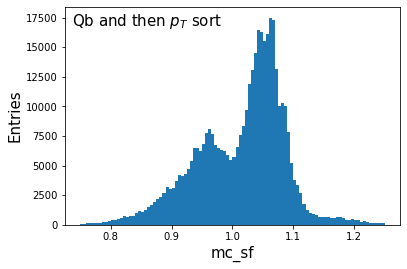

In [108]:
plt.hist(df.loc[df.njets>=4,'mc_sf'],100,(.75,1.25))
plt.xlabel('mc_sf',fontsize=15)
plt.ylabel('Entries',fontsize=15)
ax = plt.gca()
plt.text(0.02,.98,'Qb and then $p_T$ sort',fontsize=15,ha='left',va='top',transform=ax.transAxes)
plt.savefig('figures/EDA/mc_sf_4jets.pdf')

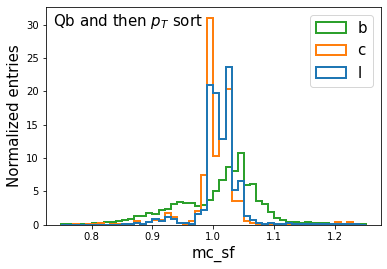

In [107]:
for f,c in zip(['b','c','l'],['C2','C1','C0']):
    v = df.loc[df.njets>=4,f'mc_sf_{f}'].values
    plt.hist(v[v!=1],50,(.75,1.25),label=f,
             histtype='step',lw=2,color=c,density=True)
plt.xlabel('mc_sf',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.legend(fontsize=15)
ax = plt.gca()
plt.text(0.02,.98,'Qb and then $p_T$ sort',fontsize=15,ha='left',va='top',transform=ax.transAxes)
plt.savefig('figures/EDA/mc_sf_bcl_4jets.pdf')

**Message:** This is a 4b sample, and the characteristic shape of the event level SF is dominated by the b-tag SFs.

In [82]:
for c in df.columns:
    print(c)

eventNumber
nresolvedJets
weight_pileup
resolved_nBTags
resolved_nValidPairings
resolved_isSR
resolved_isCR
resolved_isSB
resolved_nGoodJets
mcEventWeight
rand_run_nr
j0_pt
j0_eta
j0_phi
j0_E
j0_Db
j1_pt
j1_eta
j1_phi
j1_E
j1_Db
j2_pt
j2_eta
j2_phi
j2_E
j2_Db
j3_pt
j3_eta
j3_phi
j3_E
j3_Db
njets
X_wt
mc_sf
ntag_all


In [ ]:
plt.hist(df.loc[df.njets>=4,'mc_sf'],100,(.75,1.25))
plt.xlabel('mc_sf',fontsize=15)
plt.ylabel('Entries',fontsize=15)
ax = plt.gca()
plt.text(0.02,.98,'Qb and then $p_T$ sort',fontsize=15,ha='left',va='top',transform=ax.transAxes)

In [11]:
k

b'resolvedJets_Quantile_DL1r_Continuous'

In [26]:
# Qb = arr[b'resolved']

In [18]:
Qb = arr[b'resolvedJets_Quantile_DL1r_Continuous'][mask].flatten().reshape(-1,nresJets)

In [19]:
pt = arr[b'resolvedJets_pt'][mask].flatten().reshape(-1,nresJets)

In [54]:
nEvts = np.sum(mask)

In [62]:
rev_idx = np.arange(nj)[::-1]#*np.ones((nEvts,nj))
rev_idx

array([3, 2, 1, 0])

In [51]:
Qb[:3,::-1]

array([[5, 2, 5, 5],
       [5, 1, 4, 5],
       [1, 1, 3, 5]], dtype=int32)

In [59]:
idx_sort = np.argsort(Qb[:,::-1],axis=1)#[:,::-1]

In [50]:
idx_sort

array([[1, 0, 2, 3],
       [1, 2, 0, 3],
       [0, 1, 2, 3],
       ...,
       [0, 1, 2, 3],
       [0, 1, 3, 2],
       [0, 1, 2, 3]])

In [63]:
rev_idx[idx_sort][:,::-1]

array([[0, 1, 3, 2],
       [0, 3, 1, 2],
       [0, 1, 2, 3],
       ...,
       [0, 1, 2, 3],
       [1, 0, 2, 3],
       [0, 1, 2, 3]])

In [46]:
rev_idx[idx_sort].shape

(205042, 4, 4)

In [61]:
Qb[:,::-1][np.arange(nEvts)[:,None],idx_sort][:,::-1]

array([[ 5,  5,  5,  2],
       [ 5,  5,  4,  1],
       [ 5,  3,  1,  1],
       ...,
       [ 5,  5,  1, -1],
       [ 5,  4,  1, -1],
       [ 5,  5,  4,  1]], dtype=int32)

In [67]:
rev_idx = np.arange(4)[::-1]
Qb[np.arange(nEvts)[:,None],rev_idx[idx_sort][:,::-1]]

array([[ 5,  5,  5,  2],
       [ 5,  5,  4,  1],
       [ 5,  3,  1,  1],
       ...,
       [ 5,  5,  1, -1],
       [ 5,  4,  1, -1],
       [ 5,  5,  4,  1]], dtype=int32)

In [43]:
Qb.shape

(205042, 4)

In [37]:
Qb#[idx_sort]

array([[ 5,  5,  2,  5],
       [ 5,  4,  1,  5],
       [ 5,  3,  1,  1],
       ...,
       [ 5,  5,  1, -1],
       [ 4,  5,  1, -1],
       [ 5,  5,  4,  1]], dtype=int32)

In [25]:
np.sort(Qb[:,::-1],axis=1)[:,::-1]

array([[ 5,  5,  5,  2],
       [ 5,  5,  4,  1],
       [ 5,  3,  1,  1],
       ...,
       [ 5,  5,  1, -1],
       [ 5,  4,  1, -1],
       [ 5,  5,  4,  1]], dtype=int32)

In [21]:
pt

array([[125.70976 , 119.333145,  95.61321 ,  70.463295],
       [119.75586 ,  93.62019 ,  45.749844,  38.321266],
       [128.05933 ,  85.64215 ,  80.09014 ,  30.587053],
       ...,
       [226.0212  , 190.43803 ,  81.79146 ,  42.244556],
       [163.4549  ,  94.863266,  51.8229  ,  34.679935],
       [132.90941 ,  99.84815 ,  49.321358,  34.182884]], dtype=float32)

In [47]:
rev_idx = np.arange(nj)[::-1]
idx_b4 = rev_idx[np.argsort(is_77[:,::-1],axis=1)[:,-4]]

In [215]:
df[df.resolved_nBTags>=4].head()

eventNumber  nresolvedJets  weight_pileup  resolved_nBTags  \
entry                                                               
6           285652              8       1.081466                4   
8           286268              8       0.874719                4   
20          285989              5       1.114303                5   
30          286781              4       1.190114                4   
32          286524              6       0.925304                4   

       resolved_nValidPairings  resolved_isSR  resolved_isCR  resolved_isSB  \
entry                                                                         
6                            3          False          False          False   
8                            1           True          False          False   
20                           0          False          False          False   
30                           0          False          False          False   
32                           2          False           True          False   

       resolved_nGoodJets  mcEventWeight  ...  j2_Db      j3_pt    j3_eta  \
entry                                     ...                               
6                       0       0.031172  ...    3.0  40.357464  0.198697   
8                       1       0.031172  ...    5.0  81.043053  1.468638   
20                      0      -0.031172  ...    5.0  79.177490 -0.882091   
30                      0       0.031172  ...    0.0   0.000000  0.000000   
32                      0       0.031172  ...    5.0  49.440960 -0.519042   

         j3_phi        j3_E  j3_Db  njets      X_wt     mc_sf  ntag_all  
entry                                                                    
6      1.910041   41.662010    5.0      5  3.627701  1.083693       4.0  
8     -2.097030  185.584854    5.0      6  0.793967  1.066288       4.0  
20     2.958410  112.239594    5.0      5  2.666131  1.064185       5.0  
30     0.000000    0.000000    0.0      3 -1.000000  1.000000       3.0  
32    -1.223948   56.454632    5.0      6  0.351718  1.077451       4.0  

[5 rows x 35 columns]

In [12]:
# Get the analysis trigger decision
print(f'Applying {year} triggers')
passedTriggerHashes = tree.array(b'passedTriggerHashes')

for ti in triggers[year]:
    df[ti] = (passedTriggerHashes == hashMap[ti]).sum().astype(bool)

df['trigger'] = df[triggers[year]].sum(axis=1).astype(bool)

if mc:
    # Calculate the mcEvent Weight
    sfs = df[[f'j{i}_sf' for i in range(nJetsMax)]].values
    sfs = np.where(sfs==0, 1, sfs)
    sfs = np.prod(sfs,axis=1)
    df['mc_sf'] = df['mcEventWeight'] * df['weight_pileup'] * sfs
    df['run_number'] = df['rand_run_nr']
else:
    df['mc_sf'] = 1

df['ntag']  = np.sum(df[[f'j{i}_Db' for i in range(nJetsMax)]] >= 3, axis=1)
df['GNNJets'] = np.sum(df[[f'j{i}_pt' for i in range(nJetsMax)]] != 0, axis=1)

# Also save the truth info
if mc and truth:
    truthInfo(tree, df)
    parallelTruthMatchJets(df, nJetsMax)
    parallelGetCorrectPair(df, nJetsMax)
